In [1]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from tabulate import tabulate
import re
from hazm import Normalizer, word_tokenize, stopwords_list, Stemmer
import emoji

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, BertConfig, TFAutoModel

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.layers as Layers
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CUDA

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Read Datasets and Shuffle

In [6]:
anger = pd.read_csv('../data/persian-tweets-emotional-dataset/anger.csv')
disgust = pd.read_csv('../data/persian-tweets-emotional-dataset/disgust.csv')
fear = pd.read_csv('../data/persian-tweets-emotional-dataset/fear.csv')
joy = pd.read_csv('../data/persian-tweets-emotional-dataset/joy.csv')
sad = pd.read_csv('../data/persian-tweets-emotional-dataset/sad.csv')
surprise = pd.read_csv('../data/persian-tweets-emotional-dataset/surprise.csv')

In [7]:
cols = ['tweet', 'emotion']

data = pd.concat(
    objs = [
    	anger[cols], 
		disgust[cols], 
		fear[cols],
		joy[cols],
		sad[cols],
		surprise[cols]
    ], 	
    ignore_index=True)

data = data.sample(frac=1).reset_index(drop=True)

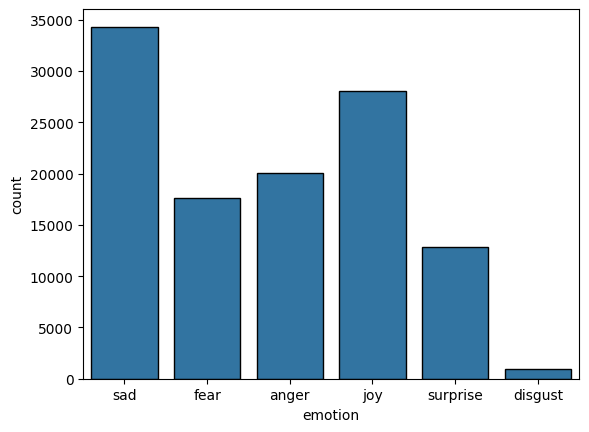

In [8]:
sea.countplot(data, x = 'emotion', edgecolor ='black')
plt.show()

# PreProcess Texts

In [35]:
def preprocess(x, html = True, url = True, username = True, hashtag = True, rep = True, norm = False, 
			   stopword = True, punctuation = True, demojize = True, stemming = True):

	if(html):
		x = re.sub(re.compile('<.*?>') , '', x)
	if(url):
		x = re.sub(r'http\S+|www\S+', '', x)
	if(username):
		x = re.sub(r'@[^ ]+', '', x)
	if(hashtag):
		x = re.sub(r'#', '', x)
	if(rep):
		x = re.sub(r'(.)\1+', r'\1', x)
	if(demojize):
		x = emoji.demojize(x, language='fa')
	if(punctuation):
		puncs = [
			'[', '!', '"', '#', '%', '\\', '\"', '(', ')', '*',
			'+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', 
			'/', '^', '_', '`', '{', '|', '}', '~',
			'’', '”', '“', '′', '‘', ']','؟','؛','«','»','،','٪'
		]
		pattern = r'[' + re.escape(''.join(puncs)) + r']'
		x = re.sub(pattern, ' ', x)
	if(norm):
		normalizer = Normalizer()
		x = normalizer.normalize(x)

	tokens = word_tokenize(x)
	
	if(stopword):
		stopwords = stopwords_list()
		tokens = [token for token in tokens if token not in stopwords]
	if(stemming):
		stemmer = Stemmer()
		tokens = [stemmer.stem(token) for token in tokens]

	x = ' '.join(tokens)
	x = x.replace("\u200c", " ")

	return x

In [26]:
example = 'سلام این متن شامل تگ </> و شامل لینک www.ut.ac.ir و شامل یوزرنیم @ut و شامل #هشتگ و شامل ایموجی 😀 و شامل علائم نگارشی! و  و شامل کلمات توقف مثل به و و شامل تکراااار حروف و شامل نیم‌فاصله است.'
print(example)


سلام این متن شامل تگ </> و شامل لینک www.ut.ac.ir و شامل یوزرنیم @ut و شامل #هشتگ و شامل ایموجی 😀 و شامل علائم نگارشی! و  و شامل کلمات توقف مثل به و و شامل تکراااار حروف و شامل نیم‌فاصله است.


In [27]:
example = preprocess(example, html = True, url = False, username = False, hashtag = False, rep = False, 
			   stopword = False, punctuation = False, demojize = False, stemming = False)
print('remove url:', example)

remove url: سلام این متن شامل تگ  و شامل لینک www.ut.ac.ir و شامل یوزرنیم @ut و شامل #هشتگ و شامل ایموجی 😀 و شامل علائم نگارشی! و  و شامل کلمات توقف مثل به و و شامل تکراااار حروف و شامل نیم‌فاصله است.


In [28]:
example = preprocess(example, html = False, url = True, username = True, hashtag = False, rep = False, 
			   stopword = False, punctuation = False, demojize = False, stemming = False)
print('remove username:', example)

remove username: سلام این متن شامل تگ  و شامل لینک  و شامل یوزرنیم  و شامل #هشتگ و شامل ایموجی 😀 و شامل علائم نگارشی! و  و شامل کلمات توقف مثل به و و شامل تکراااار حروف و شامل نیم‌فاصله است.


In [29]:
example = preprocess(example, html = False, url = True, username = False, hashtag = True, rep = False, 
			   stopword = False, punctuation = False, demojize = False, stemming = False)
print('remove hashtag:', example)

remove hashtag: سلام این متن شامل تگ  و شامل لینک  و شامل یوزرنیم  و شامل هشتگ و شامل ایموجی 😀 و شامل علائم نگارشی! و  و شامل کلمات توقف مثل به و و شامل تکراااار حروف و شامل نیم‌فاصله است.


In [30]:
example = preprocess(example, html = False, url = True, username = False, hashtag = False, rep = True, 
			   stopword = False, punctuation = False, demojize = False, stemming = False)
print('remove rep:', example)

remove rep: سلام این متن شامل تگ و شامل لینک و شامل یوزرنیم و شامل هشتگ و شامل ایموجی 😀 و شامل علائم نگارشی! و و شامل کلمات توقف مثل به و و شامل تکرار حروف و شامل نیم‌فاصله است.


In [32]:
example = preprocess(example, html = False, url = True, username = False, hashtag = False, rep = False, 
			   stopword = False, punctuation = True, demojize = False, stemming = False)
print('remove punctuation:', example)

remove punctuation: سلام این متن شامل تگ و شامل لینک و شامل یوزرنیم و شامل هشتگ و شامل ایموجی 😀 و شامل علائم نگارشی  و و شامل کلمات توقف مثل به و و شامل تکرار حروف و شامل نیم‌فاصله است 


In [34]:
example = preprocess(example, html = False, url = True, username = False, hashtag = False, rep = False, 
			   stopword = False, punctuation = False, demojize = True, stemming = False)
print('remove demojize:', example)

remove demojize: سلام این متن شامل تگ و شامل لینک و شامل یوزرنیم و شامل هشتگ و شامل ایموجی :خنده: و شامل علائم نگارشی  و و شامل کلمات توقف مثل به و و شامل تکرار حروف و شامل نیم‌فاصله است 


In [36]:
example = preprocess(example, html = False, url = True, username = False, hashtag = False, rep = False, 
			   stopword = True, punctuation = False, demojize = False, stemming = False)
print('remove stopword:', example)

remove stopword: سلام متن تگ لینک یوزرنیم هشتگ ایموجی : خنده : علائم نگارشی کلمات توقف تکرار حروف نیم فاصله


In [38]:
example = preprocess(example, html = False, url = True, username = False, hashtag = False, rep = False, 
			   stopword = False, punctuation = True, demojize = False, stemming = True)
print('stemming:', example)

stemming: سلا متن تگ لینک یوزرن هشتگ ایموج خنده علائ نگار کل توقف تکرار حروف ن فاصله


# Prepare X and y



## Apply prepeocess

In [11]:
samples = len(data)
samples

113829

In [11]:
x = data['tweet'].apply(lambda x: preprocess(x, norm=False))

In [12]:
processed_data = pd.DataFrame()
processed_data['text'] = x
processed_data['label'] = data['emotion']
processed_data.to_csv('./saved.csv')

## load

In [2]:
data = pd.read_csv('./saved.csv')
x = data['text']
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(data['label'].values.reshape(-1, 1))

# Tokenize + Embedding


## Bert

In [16]:
config = BertConfig.from_pretrained('HooshvareLab/bert-base-parsbert-uncased')
config.hidden_size = 120
bert_model = TFAutoModel.from_config(config)
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

d:\Python\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
def bert_tokenizer(texts, tokenizer, maxlen = 32):
	ids = []
	masks = []
	types = []
	for text in texts:
		o = tokenizer.encode_plus(
			text, 
			add_special_tokens=True, 
			max_length=maxlen, 
			pad_to_max_length=True,
			return_tensors='tf', 
			verbose=0
		)
		ids.append(o['input_ids'])
		masks.append(o['attention_mask'])
		types.append(o['token_type_ids'])

	return (
		np.array(ids).reshape(len(texts), maxlen),
		np.array(masks).reshape(len(texts), maxlen),
		np.array(types).reshape(len(texts), maxlen)
	)

In [19]:
out = bert_tokenizer(x, tokenizer)

In [20]:
step = 200

word_embeddings = np.empty(shape=(0, 32, 120))
iterates = samples // step
print(f"Total {iterates} will be taken")

for i in range(iterates):
	start = step * i
	end = step * (i + 1)
	end = samples if end > samples else end
	with tf.device("/gpu:0"):
		word_embeddings = np.concatenate([
				word_embeddings, 
				bert_model(
					input_ids = out[0][start : end], 
					attention_mask = out[1][start : end], 
					token_type_ids = out[2][start : end]
				)[0].numpy()
			], axis=0)
	gc.collect()
	print(f'step {i}/{iterates} done')

Total 569 will be taken
step 0/569 done
step 1/569 done
step 2/569 done
step 3/569 done
step 4/569 done
step 5/569 done
step 6/569 done
step 7/569 done
step 8/569 done
step 9/569 done
step 10/569 done
step 11/569 done
step 12/569 done
step 13/569 done
step 14/569 done
step 15/569 done
step 16/569 done
step 17/569 done
step 18/569 done
step 19/569 done
step 20/569 done
step 21/569 done
step 22/569 done
step 23/569 done
step 24/569 done
step 25/569 done
step 26/569 done
step 27/569 done
step 28/569 done
step 29/569 done
step 30/569 done
step 31/569 done
step 32/569 done
step 33/569 done
step 34/569 done
step 35/569 done
step 36/569 done
step 37/569 done
step 38/569 done
step 39/569 done
step 40/569 done
step 41/569 done
step 42/569 done
step 43/569 done
step 44/569 done
step 45/569 done
step 46/569 done
step 47/569 done
step 48/569 done
step 49/569 done
step 50/569 done
step 51/569 done
step 52/569 done
step 53/569 done
step 54/569 done
step 55/569 done
step 56/569 done
step 57/569 done


In [23]:
with open('./word_embeddings.npy', 'wb') as f:
	np.save(f, word_embeddings)

## load


In [3]:
word_embeddings = np.load('./word_embeddings.npy')
word_embeddings.shape


(113800, 32, 120)

# Train, Validation and Test

In [4]:
samples = 113800

In [5]:
word_embeddings = word_embeddings.reshape(samples, 32, 120)
y = y[:samples]

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(word_embeddings, y, test_size=0.3)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=0.2)

In [7]:
print(f'train: {ytrain.shape[0] / y.shape[0]:.2f}')
print(f'valid: {yvalid.shape[0] / y.shape[0]:.2f}')
print(f'test: {ytest.shape[0] / y.shape[0]:.2f}')


train: 0.56
valid: 0.14
test: 0.30


# Network

In [9]:
def training_metrics(history):

	epochs = range(1, len(history.history['loss']) + 1)

	plt.figure(figsize=(12, 6))
	plt.subplot(1, 2, 1)
	plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
	plt.plot(epochs, history.history['val_loss'], 'b-', label='Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()

	plt.subplot(1, 2, 2)
	plt.plot(epochs, history.history['accuracy'], 'r-', label='Training Accuracy')
	plt.plot(epochs, history.history['val_accuracy'], 'b-', label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.legend()


	plt.tight_layout()
	plt.show()



def test_metrics(y_true, y_pred, num_classes):
	accuracy = accuracy_score(y_true, y_pred)
	precision = precision_score(y_true, y_pred, average=None, labels=range(num_classes))
	recall = recall_score(y_true, y_pred, average=None, labels=range(num_classes))
	f1 = f1_score(y_true, y_pred, average=None, labels=range(num_classes))

	precision_macro = precision_score(y_true, y_pred, average='macro')
	recall_macro = recall_score(y_true, y_pred, average='macro')
	f1_macro = f1_score(y_true, y_pred, average='macro')

	precision_micro = precision_score(y_true, y_pred, average='micro')
	recall_micro = recall_score(y_true, y_pred, average='micro')
	f1_micro = f1_score(y_true, y_pred, average='micro')

	precision_weighted = precision_score(y_true, y_pred, average='weighted')
	recall_weighted = recall_score(y_true, y_pred, average='weighted')
	f1_weighted = f1_score(y_true, y_pred, average='weighted')

	accuracy_table = [["Accuracy", f"{accuracy:.4f}"]]

	class_metrics = []
	for i in range(num_classes):
		class_metrics.append([f"Class {i}", f"{precision[i]:.4f}", f"{recall[i]:.4f}", f"{f1[i]:.4f}"])

	average_metrics = [
		["Macro average", f"{precision_macro:.4f}", f"{recall_macro:.4f}", f"{f1_macro:.4f}"],
		["Micro average", f"{precision_micro:.4f}", f"{recall_micro:.4f}", f"{f1_micro:.4f}"],
		["Weighted average", f"{precision_weighted:.4f}", f"{recall_weighted:.4f}", f"{f1_weighted:.4f}"]
	]

	print(tabulate(accuracy_table, headers=["Metric", "Value"], tablefmt="grid"))
	print(tabulate(class_metrics, headers=["Class", "Precision", "Recall", "F1-score"], tablefmt="grid"))
	print(tabulate(average_metrics, headers=["Average Type", "Precision", "Recall", "F1-score"], tablefmt="grid"))

In [10]:
def cnn_lstm():
	model = Sequential()
	model.add(Layers.Input(shape=(32, 120, )))
	model.add(Layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
	model.add(Layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
	model.add(Layers.Conv1D(filters=256, kernel_size=7, activation='relu', padding='same'))
	model.add(Layers.MaxPooling1D(pool_size=2, padding='same'))
	model.add(Layers.LSTM(100, return_sequences=True))
	model.add(Layers.Flatten())
	model.add(Layers.Dense(256, activation='relu'))
	model.add(Layers.BatchNormalization())
	model.add(Layers.Dropout(0.3))
	model.add(Layers.Dense(128, activation='relu'))
	model.add(Layers.BatchNormalization())
	model.add(Layers.Dropout(0.3))
	model.add(Layers.Dense(6, activation='softmax'))

	return model



def lstm():
	model = Sequential()
	model.add(Layers.Input(shape=(32, 120, )))
	model.add(Layers.LSTM(100, return_sequences=True))
	model.add(Layers.Flatten())
	model.add(Layers.Dense(256, activation='relu'))
	model.add(Layers.BatchNormalization())
	model.add(Layers.Dropout(0.3))
	model.add(Layers.Dense(128, activation='relu'))
	model.add(Layers.BatchNormalization())
	model.add(Layers.Dropout(0.3))
	model.add(Layers.Dense(6, activation='softmax'))

	return model

def cnn():
    inputs = Layers.Input(shape=(32, 120, ))

    conv1 = Layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Layers.BatchNormalization()(conv1)
    conv1 = Layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(conv1)
    conv1 = Layers.BatchNormalization()(conv1)
    conv1 = Layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    conv1 = Layers.Dropout(0.2)(conv1)

    conv2 = Layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs)
    conv2 = Layers.BatchNormalization()(conv2)
    conv2 = Layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(conv2)
    conv2 = Layers.BatchNormalization()(conv2)
    conv2 = Layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
    conv2 = Layers.Dropout(0.2)(conv2)

    conv3 = Layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same')(inputs)
    conv3 = Layers.BatchNormalization()(conv3)
    conv3 = Layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same')(conv3)
    conv3 = Layers.BatchNormalization()(conv3)
    conv3 = Layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
    conv3 = Layers.Dropout(0.2)(conv3)

    merged = Layers.Concatenate()([conv1, conv2, conv3])
    flattened = Layers.Flatten()(merged)

    dense1 = Layers.Dense(256, activation='relu')(flattened)
    dense1 = Layers.BatchNormalization()(dense1)
    dense1 = Layers.Dropout(0.3)(dense1)
    dense2 = Layers.Dense(128, activation='relu')(dense1)
    dense2 = Layers.BatchNormalization()(dense2)
    dense2 = Layers.Dropout(0.3)(dense2)
    outputs = Layers.Dense(6, activation='softmax')(dense2)

    model = Model(inputs=inputs, outputs=outputs)
    return model

## CNN + LSTM Grid Search

In [11]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [12]:
def grid_search_cnnlstm(optimizer, learning_rate, batch_size, num_epoch = 10):
	model_name = f'optimizer_{optimizer.__name__}_learning_rate_1e{int(np.log10(learning_rate))}_batch_size_{batch_size}'
	print(model_name)

	model = cnn_lstm()
	model.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=learning_rate), metrics=['accuracy'])
	history = model.fit(
		x=xtrain,
		y=ytrain,
		validation_data=(xvalid, yvalid),
		epochs=num_epoch,
		batch_size=batch_size,
		callbacks=[early_stopping]
	)
	training_metrics(history)

	with tf.device("/cpu:0"):
		y_pred = model.predict(xtest)

	y_pred = np.argmax(y_pred, axis = 1)
	y_true = np.argmax(ytest, axis = 1)

	test_metrics(y_true, y_pred, num_classes = 6)

	model.save_weights('./' +  model_name + '.h5')

### Adam, learning rate = 1e-3, batch size = 64

optimizer_Adam_learning_rate_1e-3_batch_size_64
Epoch 1/20
996/996 [==============================] - 27s 18ms/step - loss: 1.5111 - accuracy: 0.4095 - val_loss: 1.4435 - val_accuracy: 0.4881
Epoch 2/20
996/996 [==============================] - 17s 18ms/step - loss: 0.8611 - accuracy: 0.7009 - val_loss: 0.8241 - val_accuracy: 0.7213
Epoch 3/20
996/996 [==============================] - 18s 18ms/step - loss: 0.5641 - accuracy: 0.8129 - val_loss: 0.5503 - val_accuracy: 0.8153
Epoch 4/20
996/996 [==============================] - 17s 18ms/step - loss: 0.4427 - accuracy: 0.8541 - val_loss: 0.5252 - val_accuracy: 0.8317
Epoch 5/20
996/996 [==============================] - 19s 19ms/step - loss: 0.3854 - accuracy: 0.8708 - val_loss: 0.4689 - val_accuracy: 0.8432
Epoch 6/20
996/996 [==============================] - 17s 17ms/step - loss: 0.3487 - accuracy: 0.8817 - val_loss: 0.3794 - val_accuracy: 0.8703
Epoch 7/20
996/996 [==============================] - 17s 17ms/step - loss: 0.3162 - acc

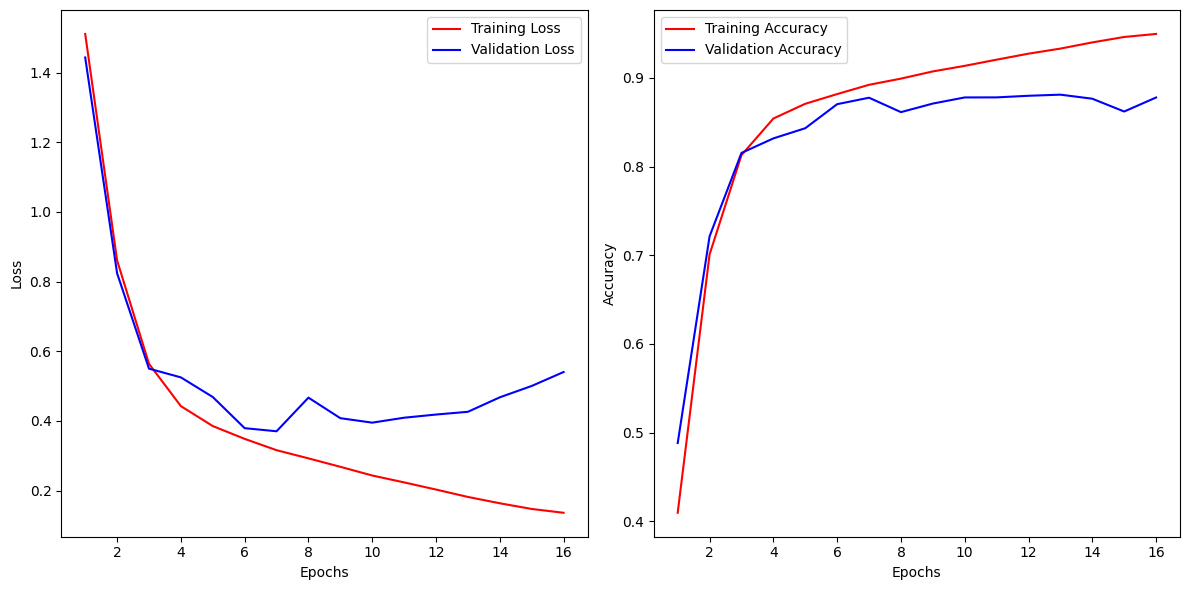

1067/1067 [==============================] - 15s 13ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |   0.872 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.8751 |   0.8554 |     0.8651 |
+---------+-------------+----------+------------+
| Class 1 |      0.9354 |   0.8066 |     0.8662 |
+---------+-------------+----------+------------+
| Class 2 |      0.9128 |   0.8722 |     0.892  |
+---------+-------------+----------+------------+
| Class 3 |      0.9083 |   0.8405 |     0.8731 |
+---------+-------------+----------+------------+
| Class 4 |      0.8139 |   0.9105 |     0.8595 |
+---------+-------------+----------+------------+
| Class 5 |      0.9103 |   0.8703 |     0.8898 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type   

In [13]:
grid_search_cnnlstm(
    optimizer = tf.keras.optimizers.Adam,
	learning_rate = 1e-3,
    batch_size = 64,
    num_epoch = 20
)

### Adam, learning rate = 1e-4, batch size = 64

optimizer_Adam_learning_rate_1e-4_batch_size_64
Epoch 1/20
996/996 [==============================] - 20s 18ms/step - loss: 1.9750 - accuracy: 0.2598 - val_loss: 1.6904 - val_accuracy: 0.3275
Epoch 2/20
996/996 [==============================] - 17s 17ms/step - loss: 1.5557 - accuracy: 0.4061 - val_loss: 1.9317 - val_accuracy: 0.4120
Epoch 3/20
996/996 [==============================] - 17s 17ms/step - loss: 1.3168 - accuracy: 0.5009 - val_loss: 1.7606 - val_accuracy: 0.3883
Epoch 4/20
996/996 [==============================] - 17s 17ms/step - loss: 1.1196 - accuracy: 0.5820 - val_loss: 1.4005 - val_accuracy: 0.5081
Epoch 5/20
996/996 [==============================] - 17s 17ms/step - loss: 0.9646 - accuracy: 0.6436 - val_loss: 1.8705 - val_accuracy: 0.3971
Epoch 6/20
996/996 [==============================] - 17s 17ms/step - loss: 0.8401 - accuracy: 0.6977 - val_loss: 1.2723 - val_accuracy: 0.5513
Epoch 7/20
996/996 [==============================] - 17s 17ms/step - loss: 0.7293 - acc

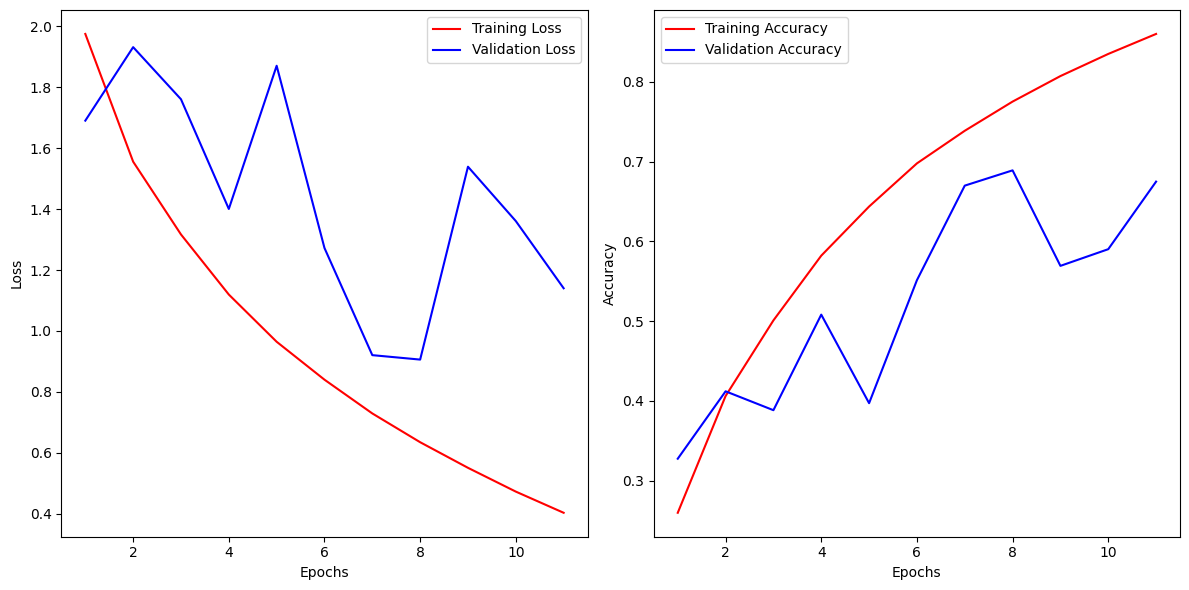

1067/1067 [==============================] - 15s 13ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.6881 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.5111 |   0.7493 |     0.6077 |
+---------+-------------+----------+------------+
| Class 1 |      0.854  |   0.4333 |     0.5749 |
+---------+-------------+----------+------------+
| Class 2 |      0.7557 |   0.6938 |     0.7234 |
+---------+-------------+----------+------------+
| Class 3 |      0.698  |   0.7501 |     0.7231 |
+---------+-------------+----------+------------+
| Class 4 |      0.7719 |   0.6244 |     0.6904 |
+---------+-------------+----------+------------+
| Class 5 |      0.8312 |   0.6363 |     0.7208 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type   

In [14]:
grid_search_cnnlstm(
    optimizer = tf.keras.optimizers.Adam,
	learning_rate = 1e-4,
    batch_size = 64,
    num_epoch = 20
)

### SGD, learning rate = 1e-3, batch size = 64

optimizer_SGD_learning_rate_1e-3_batch_size_64
Epoch 1/30
996/996 [==============================] - 24s 17ms/step - loss: 2.2414 - accuracy: 0.2018 - val_loss: 1.7060 - val_accuracy: 0.3018
Epoch 2/30
996/996 [==============================] - 17s 17ms/step - loss: 1.9531 - accuracy: 0.2477 - val_loss: 1.6455 - val_accuracy: 0.3052
Epoch 3/30
996/996 [==============================] - 17s 17ms/step - loss: 1.7908 - accuracy: 0.2985 - val_loss: 1.6233 - val_accuracy: 0.3363
Epoch 4/30
996/996 [==============================] - 17s 17ms/step - loss: 1.6836 - accuracy: 0.3343 - val_loss: 1.5595 - val_accuracy: 0.3698
Epoch 5/30
996/996 [==============================] - 17s 17ms/step - loss: 1.6083 - accuracy: 0.3636 - val_loss: 1.5363 - val_accuracy: 0.3885
Epoch 6/30
996/996 [==============================] - 17s 17ms/step - loss: 1.5440 - accuracy: 0.3892 - val_loss: 1.4384 - val_accuracy: 0.4263
Epoch 7/30
996/996 [==============================] - 17s 17ms/step - loss: 1.4877 - accu

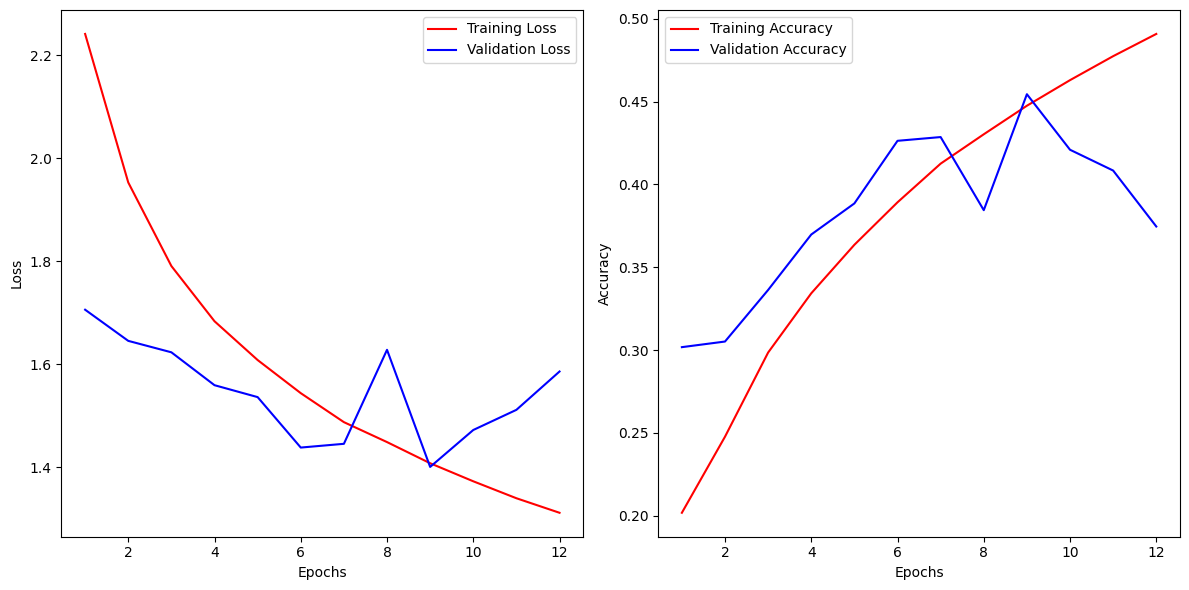

1067/1067 [==============================] - 13s 12ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.4545 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.4456 |   0.2601 |     0.3285 |
+---------+-------------+----------+------------+
| Class 1 |      0      |   0      |     0      |
+---------+-------------+----------+------------+
| Class 2 |      0.575  |   0.2182 |     0.3163 |
+---------+-------------+----------+------------+
| Class 3 |      0.5233 |   0.5792 |     0.5498 |
+---------+-------------+----------+------------+
| Class 4 |      0.4532 |   0.6187 |     0.5231 |
+---------+-------------+----------+------------+
| Class 5 |      0.298  |   0.4081 |     0.3445 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type   

d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
grid_search_cnnlstm(
    optimizer = tf.keras.optimizers.SGD,
	learning_rate = 1e-3,
    batch_size = 64,
    num_epoch = 30
)

### SGD, learning rate = 1e-4, batch size = 64

optimizer_SGD_learning_rate_1e-4_batch_size_64
Epoch 1/30
996/996 [==============================] - 26s 18ms/step - loss: 2.5346 - accuracy: 0.1748 - val_loss: 2.0911 - val_accuracy: 0.1739
Epoch 2/30
996/996 [==============================] - 16s 16ms/step - loss: 2.3532 - accuracy: 0.1866 - val_loss: 1.9653 - val_accuracy: 0.2034
Epoch 3/30
996/996 [==============================] - 17s 17ms/step - loss: 2.2628 - accuracy: 0.1982 - val_loss: 1.8672 - val_accuracy: 0.2196
Epoch 4/30
996/996 [==============================] - 16s 17ms/step - loss: 2.2011 - accuracy: 0.2045 - val_loss: 1.8355 - val_accuracy: 0.2304
Epoch 5/30
996/996 [==============================] - 16s 17ms/step - loss: 2.1502 - accuracy: 0.2106 - val_loss: 1.7879 - val_accuracy: 0.2570
Epoch 6/30
996/996 [==============================] - 16s 17ms/step - loss: 2.1025 - accuracy: 0.2211 - val_loss: 1.7430 - val_accuracy: 0.2728
Epoch 7/30
996/996 [==============================] - 17s 17ms/step - loss: 2.0674 - accu

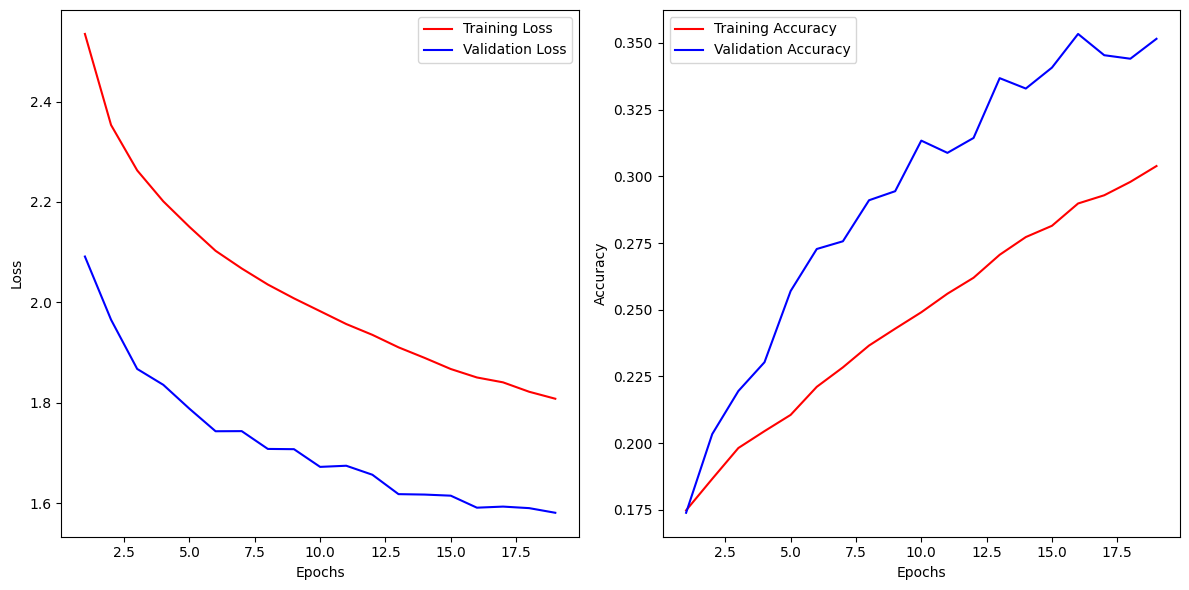

1067/1067 [==============================] - 13s 11ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.3579 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.2807 |   0.219  |     0.246  |
+---------+-------------+----------+------------+
| Class 1 |      0.0156 |   0.0037 |     0.006  |
+---------+-------------+----------+------------+
| Class 2 |      0.2717 |   0.2574 |     0.2643 |
+---------+-------------+----------+------------+
| Class 3 |      0.4497 |   0.4119 |     0.43   |
+---------+-------------+----------+------------+
| Class 4 |      0.379  |   0.5496 |     0.4486 |
+---------+-------------+----------+------------+
| Class 5 |      0.2503 |   0.1161 |     0.1586 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type   

In [13]:
grid_search_cnnlstm(
    optimizer = tf.keras.optimizers.SGD,
	learning_rate = 1e-4,
    batch_size = 64,
    num_epoch = 30
)

### Adam, learning rate = 1e-3, batch size = 8

optimizer_Adam_learning_rate_1e-3_batch_size_8
Epoch 1/10
7966/7966 [==============================] - 119s 15ms/step - loss: 1.6419 - accuracy: 0.2867 - val_loss: 1.5979 - val_accuracy: 0.3031
Epoch 2/10
7966/7966 [==============================] - 117s 15ms/step - loss: 1.5949 - accuracy: 0.2934 - val_loss: 4.6924 - val_accuracy: 0.2460
Epoch 3/10
7966/7966 [==============================] - 118s 15ms/step - loss: 1.5914 - accuracy: 0.2980 - val_loss: 69.6405 - val_accuracy: 0.2460
Epoch 4/10
7966/7966 [==============================] - 116s 15ms/step - loss: 1.5895 - accuracy: 0.3007 - val_loss: 67.3206 - val_accuracy: 0.2460


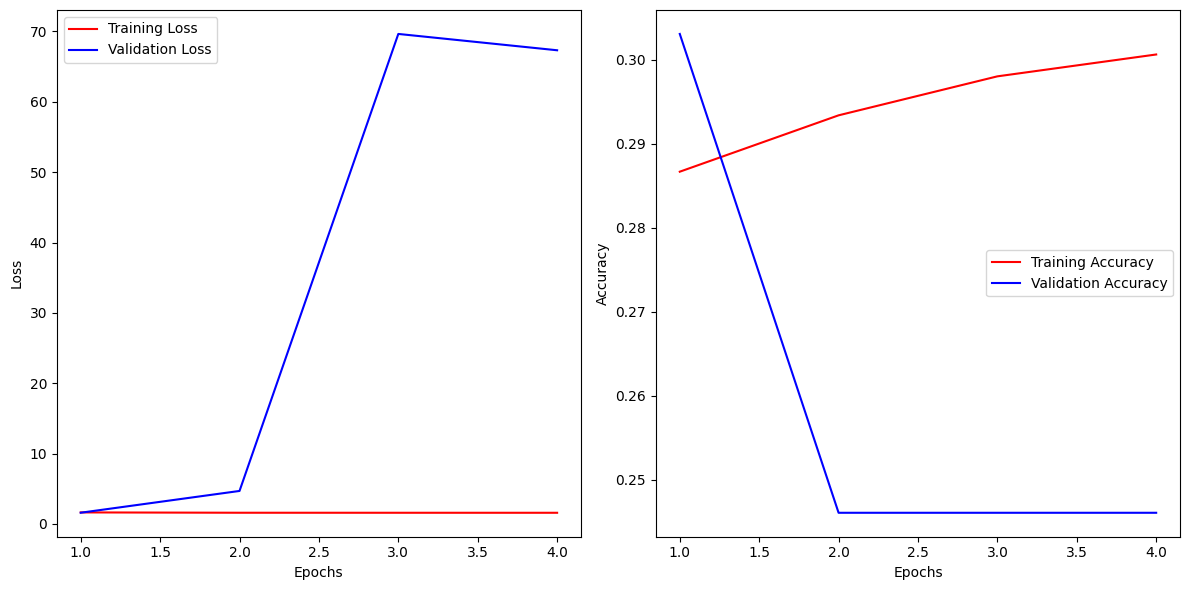

1067/1067 [==============================] - 15s 14ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.3001 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0      |        0 |     0      |
+---------+-------------+----------+------------+
| Class 1 |      0      |        0 |     0      |
+---------+-------------+----------+------------+
| Class 2 |      0      |        0 |     0      |
+---------+-------------+----------+------------+
| Class 3 |      0      |        0 |     0      |
+---------+-------------+----------+------------+
| Class 4 |      0.3001 |        1 |     0.4616 |
+---------+-------------+----------+------------+
| Class 5 |      0      |        0 |     0      |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type   

d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
grid_search_cnnlstm(
    optimizer = tf.keras.optimizers.Adam,
	learning_rate = 1e-3,
    batch_size = 8,
    num_epoch = 10
)

### Adam, learning rate = 1e-4, batch size = 8

optimizer_Adam_learning_rate_1e-4_batch_size_8
Epoch 1/10
7966/7966 [==============================] - 122s 15ms/step - loss: 1.8152 - accuracy: 0.2957 - val_loss: 1.4644 - val_accuracy: 0.4256
Epoch 2/10
7966/7966 [==============================] - 119s 15ms/step - loss: 1.4024 - accuracy: 0.4522 - val_loss: 1.2379 - val_accuracy: 0.5334
Epoch 3/10
7966/7966 [==============================] - 118s 15ms/step - loss: 1.1247 - accuracy: 0.5852 - val_loss: 1.4751 - val_accuracy: 0.5212
Epoch 4/10
7966/7966 [==============================] - 119s 15ms/step - loss: 0.8986 - accuracy: 0.6891 - val_loss: 0.9146 - val_accuracy: 0.6880
Epoch 5/10
7966/7966 [==============================] - 118s 15ms/step - loss: 0.7349 - accuracy: 0.7519 - val_loss: 0.6789 - val_accuracy: 0.7676
Epoch 6/10
7966/7966 [==============================] - 118s 15ms/step - loss: 0.6030 - accuracy: 0.8010 - val_loss: 0.6381 - val_accuracy: 0.7895
Epoch 7/10
7966/7966 [==============================] - 118s 15ms/step 

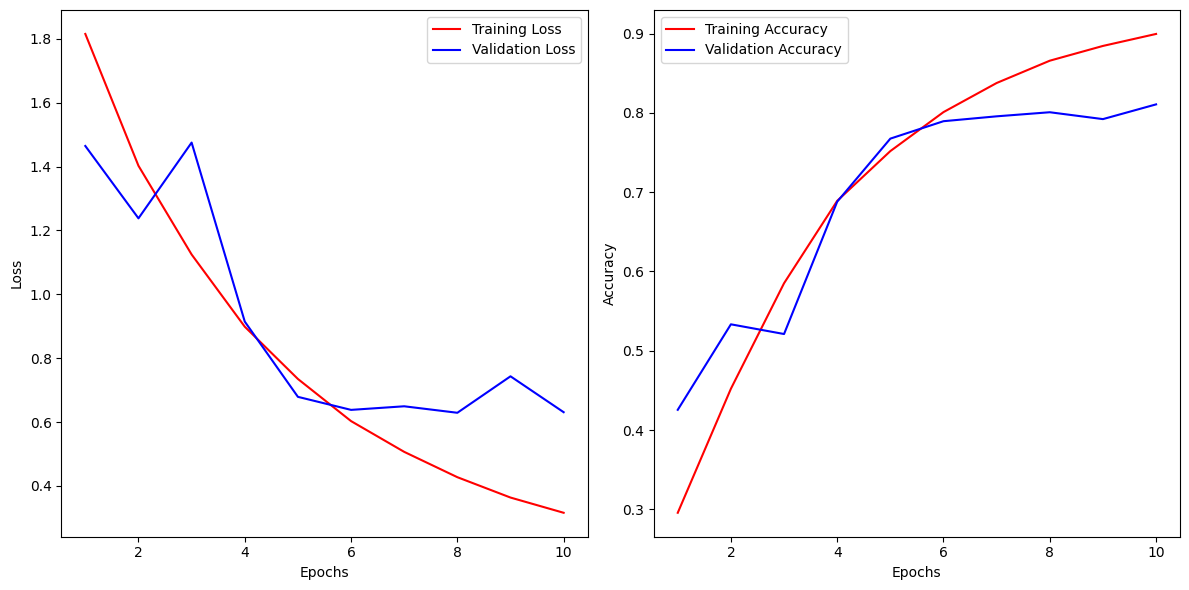

1067/1067 [==============================] - 14s 13ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.8164 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.7955 |   0.7897 |     0.7926 |
+---------+-------------+----------+------------+
| Class 1 |      0.8588 |   0.8272 |     0.8427 |
+---------+-------------+----------+------------+
| Class 2 |      0.8641 |   0.8588 |     0.8615 |
+---------+-------------+----------+------------+
| Class 3 |      0.7719 |   0.8729 |     0.8193 |
+---------+-------------+----------+------------+
| Class 4 |      0.8648 |   0.7513 |     0.8041 |
+---------+-------------+----------+------------+
| Class 5 |      0.7804 |   0.8471 |     0.8124 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type   

In [15]:
grid_search_cnnlstm(
    optimizer = tf.keras.optimizers.Adam,
	learning_rate = 1e-4,
    batch_size = 8
)

### SGD, learning rate = 1e-3, batch size = 8

optimizer_SGD_learning_rate_1e-3_batch_size_8
Epoch 1/30
7966/7966 [==============================] - 150s 18ms/step - loss: 1.8264 - accuracy: 0.2680 - val_loss: 1.5128 - val_accuracy: 0.3629
Epoch 2/30
7966/7966 [==============================] - 138s 17ms/step - loss: 1.5047 - accuracy: 0.3856 - val_loss: 1.6114 - val_accuracy: 0.3817
Epoch 3/30
7966/7966 [==============================] - 135s 17ms/step - loss: 1.3777 - accuracy: 0.4557 - val_loss: 1.3858 - val_accuracy: 0.4755
Epoch 4/30
7966/7966 [==============================] - 136s 17ms/step - loss: 1.2838 - accuracy: 0.5035 - val_loss: 1.2710 - val_accuracy: 0.4989
Epoch 5/30
7966/7966 [==============================] - 137s 17ms/step - loss: 1.1873 - accuracy: 0.5536 - val_loss: 1.1355 - val_accuracy: 0.5786
Epoch 6/30
7966/7966 [==============================] - 142s 18ms/step - loss: 1.0834 - accuracy: 0.5998 - val_loss: 1.1075 - val_accuracy: 0.5923
Epoch 7/30
7966/7966 [==============================] - 138s 17ms/step -

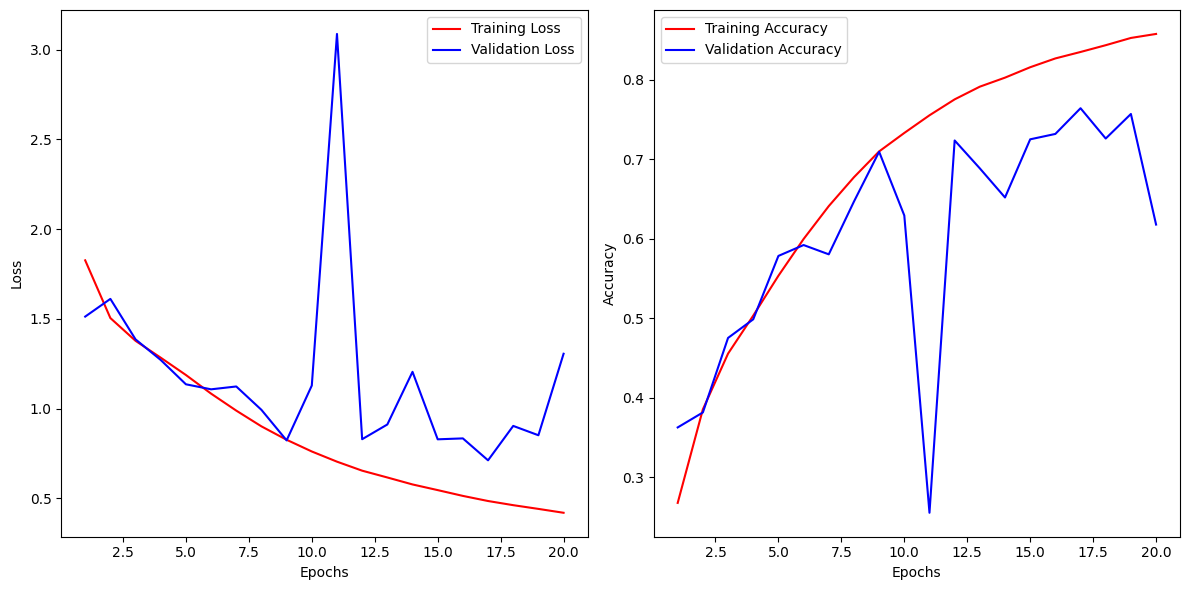

1067/1067 [==============================] - 13s 12ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.7625 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.7078 |   0.7358 |     0.7215 |
+---------+-------------+----------+------------+
| Class 1 |      0.9014 |   0.7007 |     0.7885 |
+---------+-------------+----------+------------+
| Class 2 |      0.7522 |   0.8575 |     0.8014 |
+---------+-------------+----------+------------+
| Class 3 |      0.7172 |   0.864  |     0.7837 |
+---------+-------------+----------+------------+
| Class 4 |      0.8927 |   0.6124 |     0.7265 |
+---------+-------------+----------+------------+
| Class 5 |      0.7465 |   0.849  |     0.7945 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type   

In [13]:
grid_search_cnnlstm(
    optimizer = tf.keras.optimizers.SGD,
	learning_rate = 1e-3,
    batch_size = 8,
	num_epoch = 30
)

### SGD, learning rate = 1e-4, batch size = 8

optimizer_SGD_learning_rate_1e-4_batch_size_8
Epoch 1/30
7966/7966 [==============================] - 158s 18ms/step - loss: 2.2919 - accuracy: 0.1990 - val_loss: 1.7089 - val_accuracy: 0.2887
Epoch 2/30
7966/7966 [==============================] - 134s 17ms/step - loss: 2.0250 - accuracy: 0.2353 - val_loss: 1.6303 - val_accuracy: 0.3471
Epoch 3/30
7966/7966 [==============================] - 140s 18ms/step - loss: 1.8958 - accuracy: 0.2672 - val_loss: 1.5778 - val_accuracy: 0.3649
Epoch 4/30
7966/7966 [==============================] - 140s 18ms/step - loss: 1.7970 - accuracy: 0.3000 - val_loss: 1.5186 - val_accuracy: 0.3867
Epoch 5/30
7966/7966 [==============================] - 141s 18ms/step - loss: 1.7274 - accuracy: 0.3199 - val_loss: 1.4860 - val_accuracy: 0.4028
Epoch 6/30
7966/7966 [==============================] - 142s 18ms/step - loss: 1.6685 - accuracy: 0.3398 - val_loss: 1.4612 - val_accuracy: 0.4160
Epoch 7/30
7966/7966 [==============================] - 140s 18ms/step -

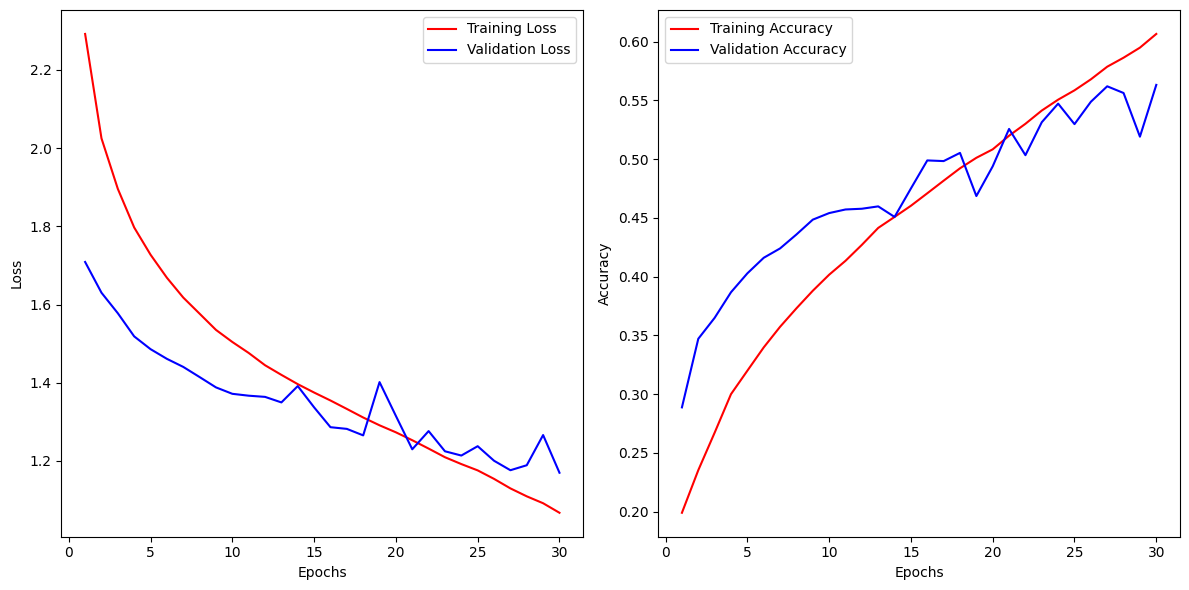

1067/1067 [==============================] - 15s 13ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.5634 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.3934 |   0.649  |     0.4899 |
+---------+-------------+----------+------------+
| Class 1 |      1      |   0.0036 |     0.0073 |
+---------+-------------+----------+------------+
| Class 2 |      0.7612 |   0.3829 |     0.5095 |
+---------+-------------+----------+------------+
| Class 3 |      0.7705 |   0.5627 |     0.6504 |
+---------+-------------+----------+------------+
| Class 4 |      0.5453 |   0.6758 |     0.6036 |
+---------+-------------+----------+------------+
| Class 5 |      0.6015 |   0.4239 |     0.4973 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type   

In [13]:
grid_search_cnnlstm(
    optimizer = tf.keras.optimizers.SGD,
	learning_rate = 1e-4,
    batch_size = 8,
    num_epoch = 30
)

## Optimized Parameters

In [16]:
optimizer = tf.keras.optimizers.Adam
learning_rate = 1e-3
batch_size = 64


# CNN

In [13]:
num_epoch = 25
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

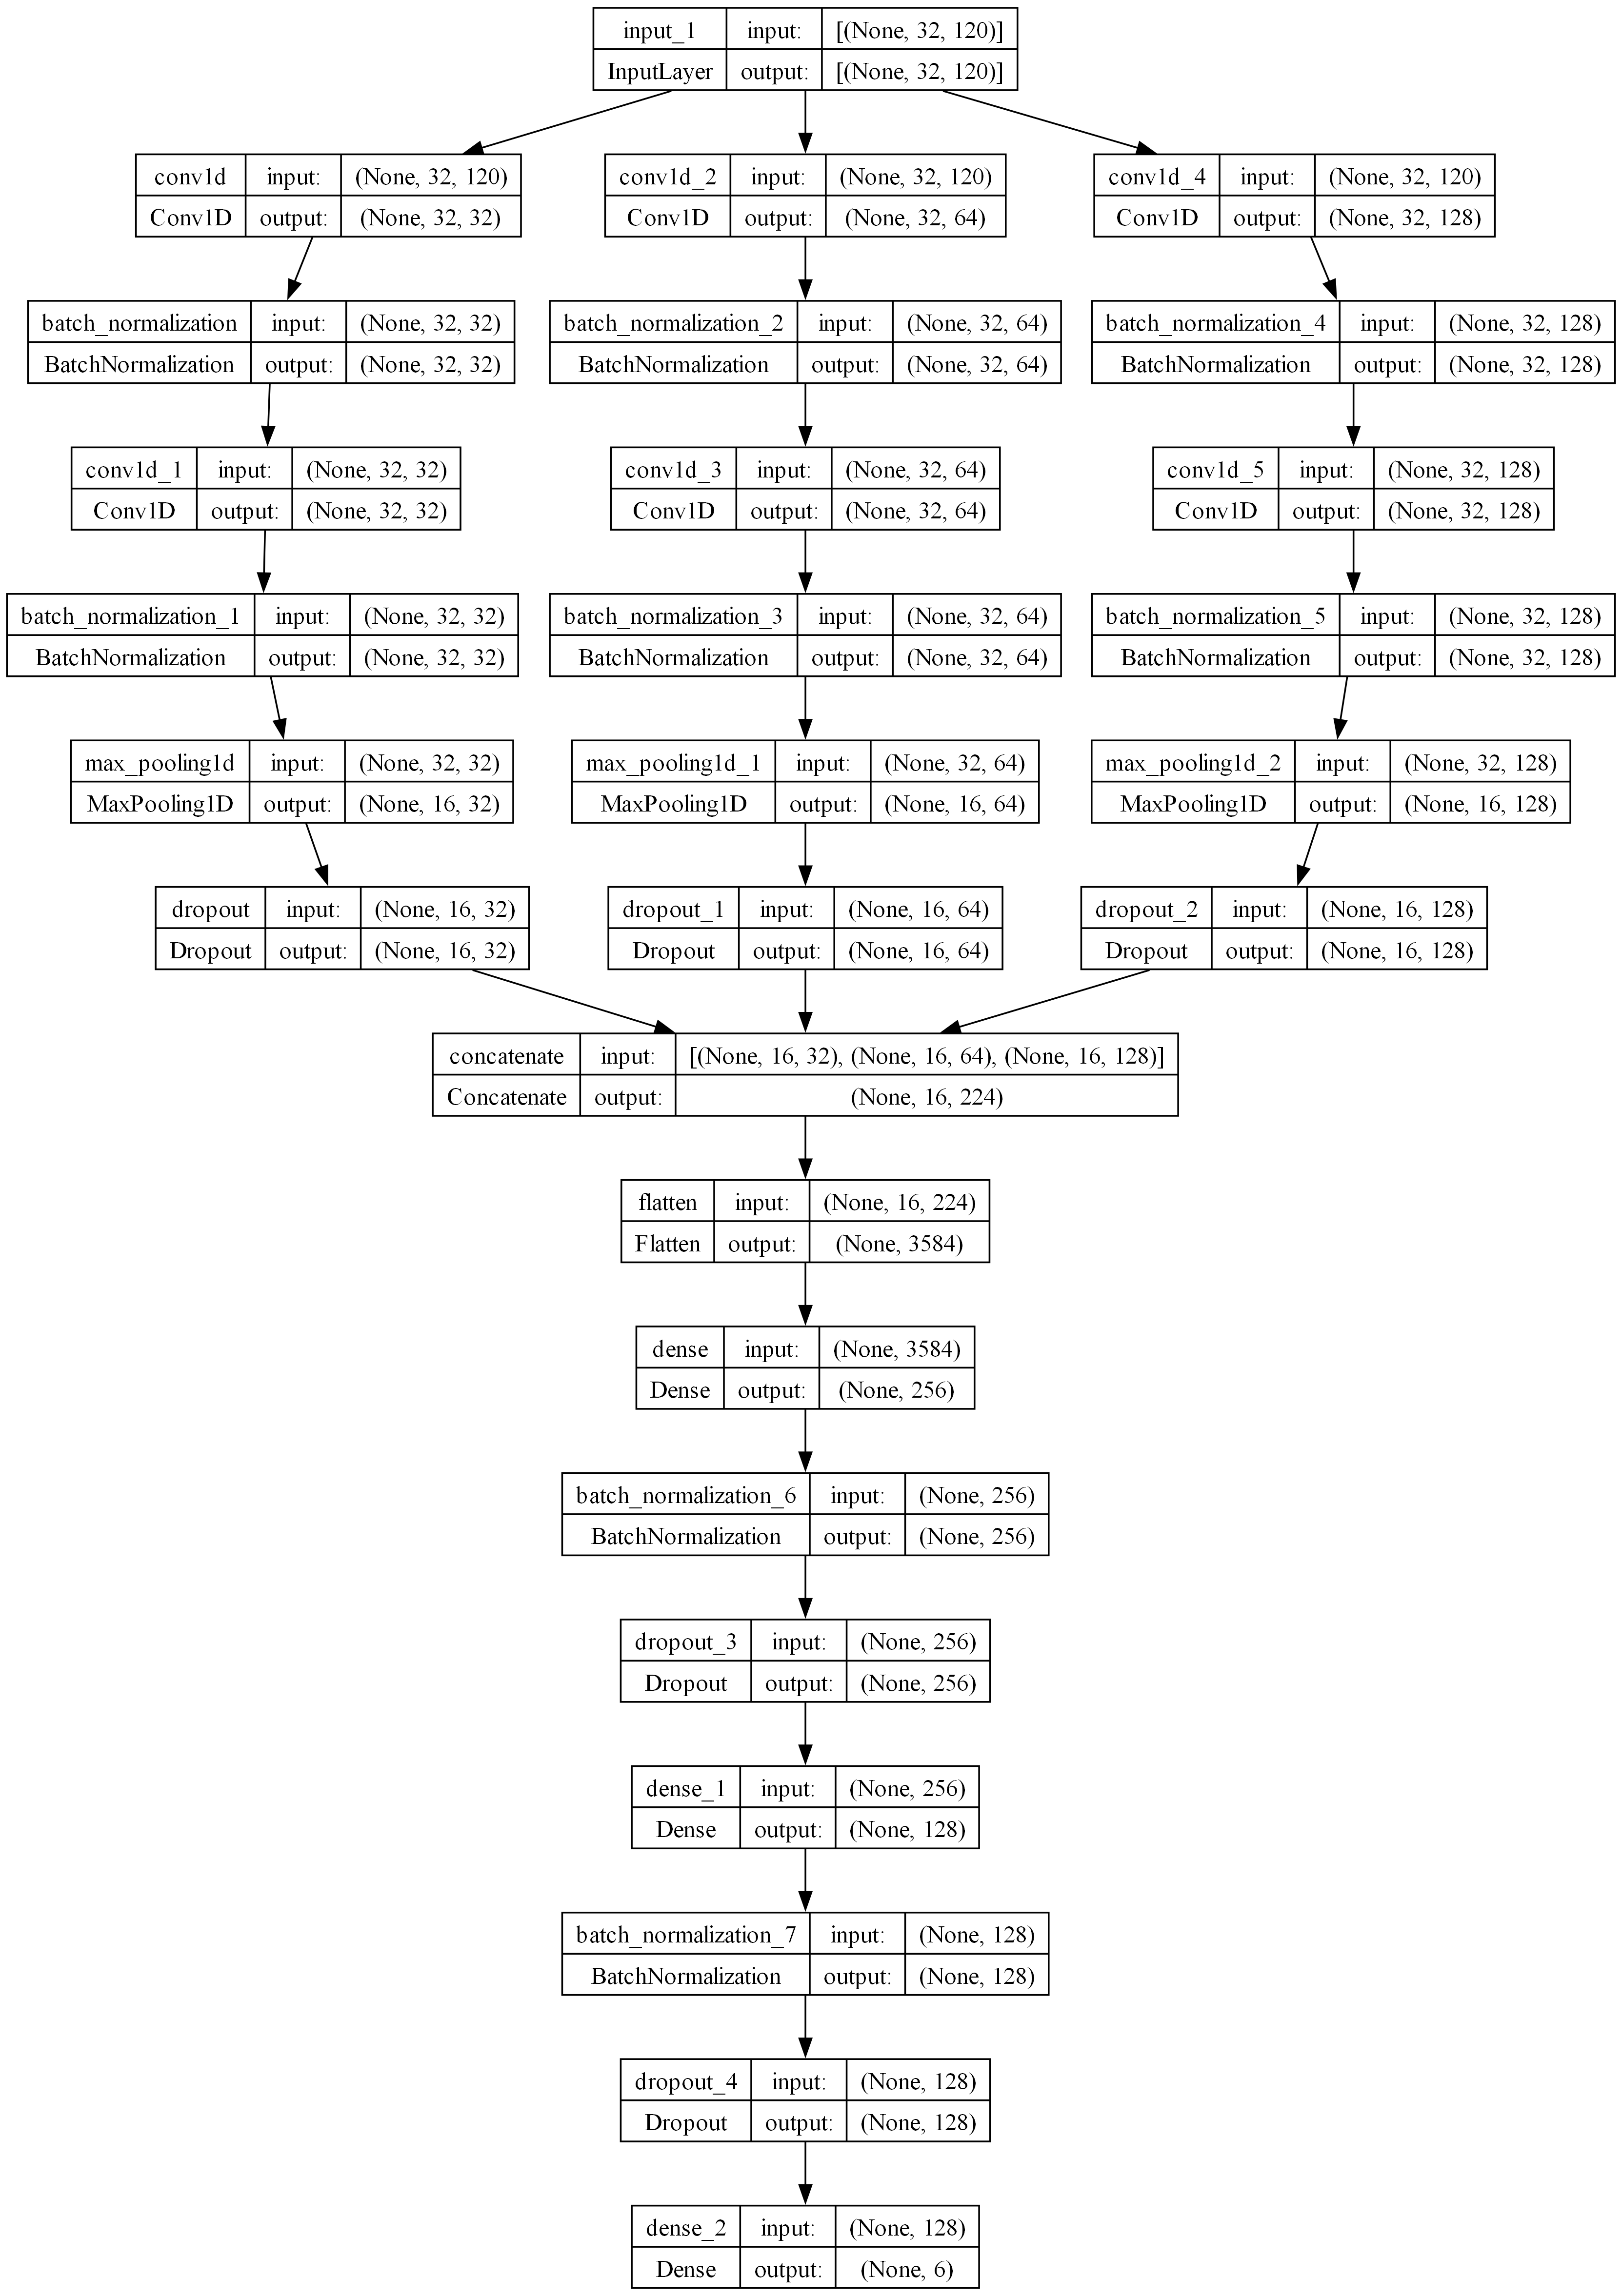

In [14]:
model = cnn()
plot_model(
    model, 
    show_shapes = True,
    show_dtype=False,
    show_layer_names = True, 
    rankdir = 'TB', 
    expand_nested = False, 
    dpi = 256
)

Epoch 1/25
996/996 [==============================] - 36s 26ms/step - loss: 1.5704 - accuracy: 0.3775 - val_loss: 1.3204 - val_accuracy: 0.4724
Epoch 2/25
996/996 [==============================] - 26s 26ms/step - loss: 1.0438 - accuracy: 0.6137 - val_loss: 0.9615 - val_accuracy: 0.6590
Epoch 3/25
996/996 [==============================] - 26s 26ms/step - loss: 0.7663 - accuracy: 0.7306 - val_loss: 0.7311 - val_accuracy: 0.7386
Epoch 4/25
996/996 [==============================] - 26s 26ms/step - loss: 0.6073 - accuracy: 0.7924 - val_loss: 0.5682 - val_accuracy: 0.8019
Epoch 5/25
996/996 [==============================] - 27s 27ms/step - loss: 0.5162 - accuracy: 0.8245 - val_loss: 0.6439 - val_accuracy: 0.7837
Epoch 6/25
996/996 [==============================] - 27s 27ms/step - loss: 0.4441 - accuracy: 0.8493 - val_loss: 0.4839 - val_accuracy: 0.8377
Epoch 7/25
996/996 [==============================] - 27s 27ms/step - loss: 0.3942 - accuracy: 0.8660 - val_loss: 0.5014 - val_accuracy:

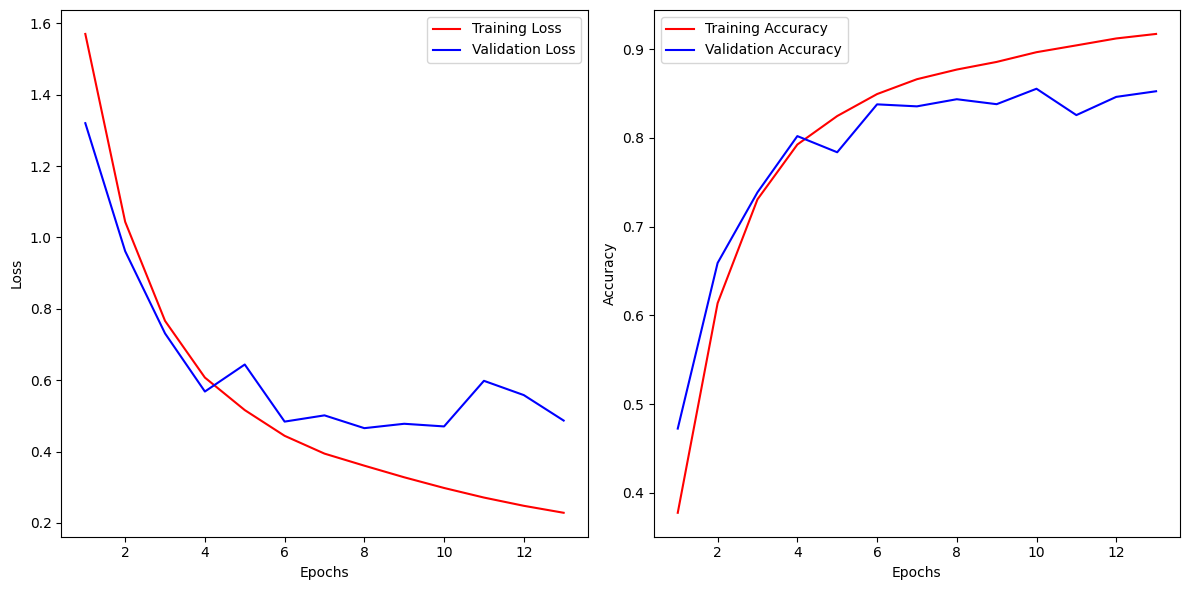

1067/1067 [==============================] - 15s 14ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.8569 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.7824 |   0.8569 |     0.8179 |
+---------+-------------+----------+------------+
| Class 1 |      0.8905 |   0.8502 |     0.8699 |
+---------+-------------+----------+------------+
| Class 2 |      0.9138 |   0.8453 |     0.8782 |
+---------+-------------+----------+------------+
| Class 3 |      0.886  |   0.8301 |     0.8571 |
+---------+-------------+----------+------------+
| Class 4 |      0.8285 |   0.8962 |     0.861  |
+---------+-------------+----------+------------+
| Class 5 |      0.9428 |   0.8266 |     0.8809 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type   

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=learning_rate), metrics=['accuracy'])
history = model.fit(
	x=xtrain,
	y=ytrain,
	validation_data=(xvalid, yvalid),
	epochs=num_epoch,
	batch_size=batch_size,
	callbacks=[early_stopping]
)
training_metrics(history)


num_classes = 6

with tf.device("/cpu:0"):
	y_pred = model.predict(xtest)

y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(ytest, axis = 1)

test_metrics(y_true, y_pred, num_classes)

# LSTM

In [18]:
optimizer = tf.keras.optimizers.Adam
learning_rate = 1e-3
batch_size = 64
num_epoch = 25

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [19]:
model = lstm()
# model.summary()

Epoch 1/25
996/996 [==============================] - 18s 15ms/step - loss: 1.3068 - accuracy: 0.5132 - val_loss: 1.5608 - val_accuracy: 0.5406
Epoch 2/25
996/996 [==============================] - 14s 14ms/step - loss: 0.6802 - accuracy: 0.7677 - val_loss: 0.7674 - val_accuracy: 0.7642
Epoch 3/25
996/996 [==============================] - 14s 14ms/step - loss: 0.4921 - accuracy: 0.8357 - val_loss: 0.7381 - val_accuracy: 0.7702
Epoch 4/25
996/996 [==============================] - 14s 14ms/step - loss: 0.4005 - accuracy: 0.8681 - val_loss: 0.9756 - val_accuracy: 0.6732
Epoch 5/25
996/996 [==============================] - 14s 14ms/step - loss: 0.3542 - accuracy: 0.8824 - val_loss: 0.5741 - val_accuracy: 0.8288
Epoch 6/25
996/996 [==============================] - 13s 14ms/step - loss: 0.3185 - accuracy: 0.8940 - val_loss: 0.7778 - val_accuracy: 0.7873
Epoch 7/25
996/996 [==============================] - 14s 14ms/step - loss: 0.2901 - accuracy: 0.9021 - val_loss: 0.6216 - val_accuracy:

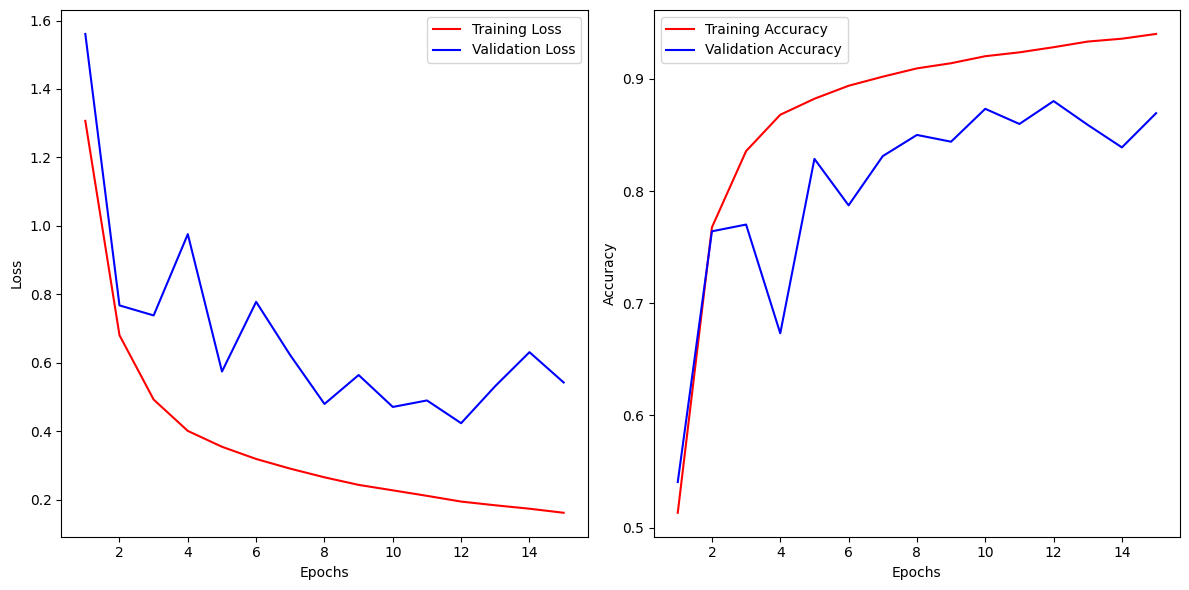

1067/1067 [==============================] - 9s 8ms/step
+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.8781 |
+----------+---------+
+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-score |
+=========+=============+==========+============+
| Class 0 |      0.8867 |   0.8562 |     0.8712 |
+---------+-------------+----------+------------+
| Class 1 |      0.9094 |   0.9094 |     0.9094 |
+---------+-------------+----------+------------+
| Class 2 |      0.8991 |   0.8774 |     0.8881 |
+---------+-------------+----------+------------+
| Class 3 |      0.8437 |   0.9014 |     0.8716 |
+---------+-------------+----------+------------+
| Class 4 |      0.8888 |   0.871  |     0.8798 |
+---------+-------------+----------+------------+
| Class 5 |      0.8856 |   0.8793 |     0.8824 |
+---------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     

In [20]:

model.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=learning_rate), metrics=['accuracy'])
history = model.fit(
	x=xtrain,
	y=ytrain,
	validation_data=(xvalid, yvalid),
	epochs=num_epoch,
	batch_size=batch_size,
	callbacks=[early_stopping]
)
training_metrics(history)


num_classes = 6

with tf.device("/cpu:0"):
	y_pred = model.predict(xtest)

y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(ytest, axis = 1)

test_metrics(y_true, y_pred, num_classes)

# Machine Learning

In [9]:
samples = 20000

In [10]:
labels = np.argmax(y[:samples], axis = 1)

In [11]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['text'][:samples])

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [12]:
def MLClassifier(classifiers):
	results = []
	classification_reports = {}

	for name, clf in classifiers.items():
		clf.fit(X_train, y_train)
		y_pred = clf.predict(X_test)
		accuracy = accuracy_score(y_test, y_pred)
		results.append([name, accuracy])
		classification_reports[name] = classification_report(y_test, y_pred, output_dict=True)

	print(tabulate(results, headers=["Classifier", "Accuracy"], tablefmt="grid"))

	for name, report in classification_reports.items():
		print(f"\nClassification Report for {name}:")
		report_table = []
		for label, metrics in report.items():
			if label not in ["accuracy", "macro avg", "weighted avg"]:
				report_table.append([label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])
		print(tabulate(report_table, headers=["Class", "Precision", "Recall", "F1-score", "Support"], tablefmt="grid"))

	average_metrics_table = []
	for name, report in classification_reports.items():
		macro_avg = report["macro avg"]
		weighted_avg = report["weighted avg"]
		average_metrics_table.append([
			name,
			macro_avg['precision'],
			macro_avg['recall'],
			macro_avg['f1-score'],
			weighted_avg['precision'],
			weighted_avg['recall'],
			weighted_avg['f1-score']
		])

	print("\nAverage Metrics:")
	print(tabulate(
		average_metrics_table, 
		headers = [
			"Classifier", 
			"Macro Precision", 
			"Macro Recall", 
			"Macro F1-score", 
			"Weighted Precision", 
			"Weighted Recall", 
			"Weighted F1-score"
		], 
		tablefmt="grid"
	))

In [35]:
MLClassifier(classifiers = {
		"Gaussian Naive Bayes": GaussianNB(),
})

+----------------------+------------+
| Classifier           |   Accuracy |
+======================+============+
| Gaussian Naive Bayes |    0.35025 |
+----------------------+------------+

Classification Report for Gaussian Naive Bayes:
+---------+-------------+-----------+------------+-----------+
|   Class |   Precision |    Recall |   F1-score |   Support |
+=========+=============+===========+============+===========+
|       0 |    0.371179 | 0.35124   |  0.360934  |       726 |
+---------+-------------+-----------+------------+-----------+
|       1 |    0.25     | 0.0344828 |  0.0606061 |        29 |
+---------+-------------+-----------+------------+-----------+
|       2 |    0.327343 | 0.430017  |  0.37172   |       593 |
+---------+-------------+-----------+------------+-----------+
|       3 |    0.450723 | 0.35      |  0.394026  |       980 |
+---------+-------------+-----------+------------+-----------+
|       4 |    0.451398 | 0.281095  |  0.346449  |      1206 |
+----

In [38]:
MLClassifier(classifiers = {
		"Logistic Regression": LogisticRegression(max_iter=1000)
})

+---------------------+------------+
| Classifier          |   Accuracy |
+=====================+============+
| Logistic Regression |      0.897 |
+---------------------+------------+

Classification Report for Logistic Regression:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+============+===========+
|       0 |    0.894882 | 0.891185 |   0.89303  |       726 |
+---------+-------------+----------+------------+-----------+
|       1 |    0.964286 | 0.931034 |   0.947368 |        29 |
+---------+-------------+----------+------------+-----------+
|       2 |    0.917832 | 0.885329 |   0.901288 |       593 |
+---------+-------------+----------+------------+-----------+
|       3 |    0.905057 | 0.894898 |   0.899949 |       980 |
+---------+-------------+----------+------------+-----------+
|       4 |    0.866086 | 0.906302 |   0.885737 |      1206 |
+---------+------------

In [13]:
MLClassifier(classifiers = {
		"Decision Tree": DecisionTreeClassifier(),
})

+---------------+------------+
| Classifier    |   Accuracy |
+===============+============+
| Decision Tree |      0.872 |
+---------------+------------+

Classification Report for Decision Tree:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+============+===========+
|       0 |    0.872253 | 0.874656 |   0.873453 |       726 |
+---------+-------------+----------+------------+-----------+
|       1 |    0.84375  | 0.931034 |   0.885246 |        29 |
+---------+-------------+----------+------------+-----------+
|       2 |    0.886598 | 0.870152 |   0.878298 |       593 |
+---------+-------------+----------+------------+-----------+
|       3 |    0.886831 | 0.879592 |   0.883197 |       980 |
+---------+-------------+----------+------------+-----------+
|       4 |    0.844517 | 0.855721 |   0.850082 |      1206 |
+---------+-------------+----------+------------+----------

In [14]:
MLClassifier(classifiers = {
		"Random Forest": RandomForestClassifier(),
})

+---------------+------------+
| Classifier    |   Accuracy |
+===============+============+
| Random Forest |    0.89825 |
+---------------+------------+

Classification Report for Random Forest:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+============+===========+
|       0 |    0.938596 | 0.884298 |   0.910638 |       726 |
+---------+-------------+----------+------------+-----------+
|       1 |    0.961538 | 0.862069 |   0.909091 |        29 |
+---------+-------------+----------+------------+-----------+
|       2 |    0.942446 | 0.883642 |   0.912097 |       593 |
+---------+-------------+----------+------------+-----------+
|       3 |    0.888    | 0.906122 |   0.89697  |       980 |
+---------+-------------+----------+------------+-----------+
|       4 |    0.846978 | 0.91791  |   0.881019 |      1206 |
+---------+-------------+----------+------------+----------